کتابخانه های مورد نیاز

دانلود دیتاست مورد استفاده:   https://www.mediafire.com/file/j03djpy140rno4d/data.rar/file

In [27]:
import os
import cv2
import numpy as np
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

from PIL import Image 
import random
import tensorflow as tf  

به جهت ثابت نگه داشتن دقت

In [28]:
seed_value = 42
np.random.seed(seed_value)  
random.seed(seed_value)  
tf.random.set_seed(seed_value) 

وارد کردن دیتاست

In [29]:
data_dir = "data"  
categories = os.listdir(data_dir) 

داده‌ها و برچسب‌ها 

In [30]:
images = []
labels = []

فرمت‌های تصویری پشتیبانی‌شده

In [31]:
valid_formats = ('.jpg', '.png', '.gif', '.jpeg')

تعداد تصاویر در هر پوشه

In [32]:
for category in categories:  
    category_path = os.path.join(data_dir, category)
    image_count = len([file for file in os.listdir(category_path) if file.lower().endswith(valid_formats)])
    print(f"Number_Images_'{category}' : {image_count} images.")


Number_Images_'Angry' : 86 images.
Number_Images_'Happy' : 100 images.
Number_Images_'Sad' : 79 images.


تعداد فرمت های تصاویر برای هر احساس

In [33]:
for category in categories:
    category_path = os.path.join(data_dir, category)
    format_count = {ext: 0 for ext in valid_formats}
    
    for file in os.listdir(category_path):
        file_lower = file.lower()
        for ext in valid_formats:
            if file_lower.endswith(ext):
                format_count[ext] += 1

    print(f"Emotion: '{category}'")
    for ext, count in format_count.items():
        print(f"  {ext}:  {count}")


Emotion: 'Angry'
  .jpg:  67
  .png:  14
  .gif:  0
  .jpeg:  5
Emotion: 'Happy'
  .jpg:  80
  .png:  8
  .gif:  0
  .jpeg:  12
Emotion: 'Sad'
  .jpg:  69
  .png:  4
  .gif:  1
  .jpeg:  5


تغییر سایز

In [34]:
img_size = 32

بارگذاری و پردازش تصاویر

In [35]:
for label, category in enumerate(categories):  
    category_path = os.path.join(data_dir, category)  
    for file in os.listdir(category_path):  
        if file.lower().endswith(valid_formats):  
            file_path = os.path.join(category_path, file)  
            try:  
                if file.lower().endswith('.gif'):  
                    img = Image.open(file_path)  # برای لحاظ gif  
                    img = img.convert('RGB')  # تبدیل به  RGB  
                    img_resized = img.resize((img_size, img_size), Image.LANCZOS)  # تغییر اندازه با آنتی‌الیزینگ  
                    img_resized = cv2.cvtColor(np.array(img_resized), cv2.COLOR_RGB2BGR)  # تبدیل به  OpenCV  
                else:  
                    img = cv2.imread(file_path, cv2.IMREAD_COLOR)  # بارگذاری سایر تصاویر با OpenCV  
                    if img is not None:  
                        img_resized = cv2.resize(img, (img_size, img_size))  

                images.append(img_resized)  # اضافه کردن تصویر تغییر اندازه داده شده  
                labels.append(label) 
            except Exception as e:  
                print(f"Error processing {file_path}: {e}")

 و نرمال سازی تبدیل به آرایه numpy 

In [36]:
images = np.array(images) / 255.0  
labels = np.array(labels)

ورود لیبل ها به صورت one hot

In [37]:
labels = to_categorical(labels, num_classes=len(categories))


تقسیم داده‌های آموزشی و آزمایشی

In [38]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


تعریف residual block

In [39]:
def residual_block(x, filters, kernel_size=3, strides=1):
    shortcut = x

    #convolution_1
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    #convolution_2
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # تنظیم shortcut اگر ابعاد نامتناسب باشد
    if strides != 1 or int(x.shape[-1]) != int(shortcut.shape[-1]):
        shortcut = Conv2D(filters, 1, strides=strides, padding='same')(shortcut)

    # اضافه کردن shortcut
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

تعریف لایه ورودی

In [40]:
input_layer = Input(shape=(img_size, img_size, 3))


لایه‌های ابتدایی

In [41]:
x = Conv2D(64, 7, strides=2, padding='same')(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

بلاک‌های باقیمانده

In [42]:
x = residual_block(x, 64)
x = residual_block(x, 64)
x = residual_block(x, 128, strides=2)
x = residual_block(x, 128)
x = residual_block(x, 256, strides=2)
x = residual_block(x, 256)
x = residual_block(x, 512, strides=2)
x = residual_block(x, 512)

لایه‌های نهایی

In [43]:
x = GlobalAveragePooling2D()(x)
output_layer = Dense(len(categories), activation='softmax')(x)

ساخت مدل 

In [44]:
model = Model(inputs=input_layer, outputs=output_layer)

کامپایل مدل

In [45]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

آموزش مدل

In [46]:
history = model.fit(X_train, y_train, epochs=90, batch_size=20, validation_data=(X_test, y_test))  


Epoch 1/90
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 382ms/step - accuracy: 0.3374 - loss: 3.2740 - val_accuracy: 0.3774 - val_loss: 1.4715
Epoch 2/90
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 295ms/step - accuracy: 0.5014 - loss: 1.6117 - val_accuracy: 0.4340 - val_loss: 1.2369
Epoch 3/90
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - accuracy: 0.6075 - loss: 1.0421 - val_accuracy: 0.3962 - val_loss: 1.4432
Epoch 4/90
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 276ms/step - accuracy: 0.5599 - loss: 0.9409 - val_accuracy: 0.3019 - val_loss: 1.2485
Epoch 5/90
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 289ms/step - accuracy: 0.7868 - loss: 0.5857 - val_accuracy: 0.3962 - val_loss: 1.1665
Epoch 6/90
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step - accuracy: 0.9178 - loss: 0.3059 - val_accuracy: 0.2830 - val_loss: 1.1300
Epoch 7/90
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 288ms/step - accuracy: 0.9800 - loss: 0.1184 - val_accuracy: 0.2830 - val_loss: 1.1650
Epoch 8/90
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 273ms/step - accuracy: 0.9548 - loss: 0.0956 - val_accuracy: 0

ارزیابی مدل

In [47]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5900 - loss: 2.7026
Test Accuracy: 60.38%


رسم نمودار

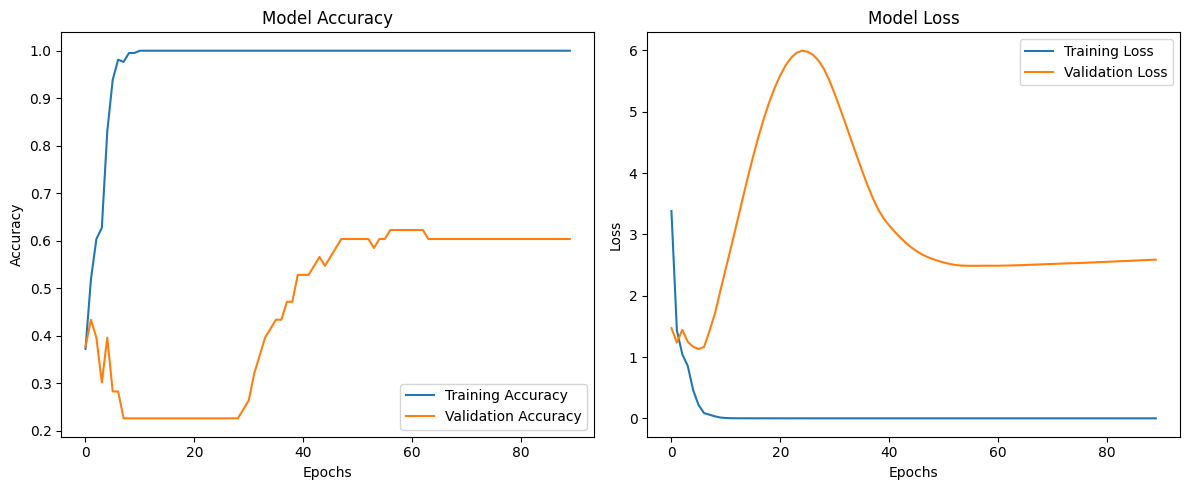

In [48]:
# accuracy  
plt.figure(figsize=(12, 5))  
plt.subplot(1, 2, 1)  
plt.plot(history.history['accuracy'], label='Training Accuracy')  
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  
plt.title('Model Accuracy')  
plt.xlabel('Epochs')  
plt.ylabel('Accuracy')  
plt.legend(loc='lower right')  

# loss  
plt.subplot(1, 2, 2)  
plt.plot(history.history['loss'], label='Training Loss')  
plt.plot(history.history['val_loss'], label='Validation Loss')  
plt.title('Model Loss')  
plt.xlabel('Epochs')  
plt.ylabel('Loss')  
plt.legend(loc='upper right')  

#------------------------------------------------------------------

plt.tight_layout()  
plt.show()